피처 앙상블 이용해서 다시 뽑기

c:\Users\xison\anaconda3\envs\pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [04:05:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 229600, number of negative: 44290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8147
[LightGBM] [Info] Number of data points in the train set: 273890, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.838293 -> initscore=1.645580
[LightGBM] [Info] Start training from score 1.645580


C:\Users\xison\AppData\Local\Temp\ipykernel_23168\1939002144.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\xison\AppData\Local\Temp\ipykernel_23168\1939002144.py:75: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
c:\Users\xison\anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


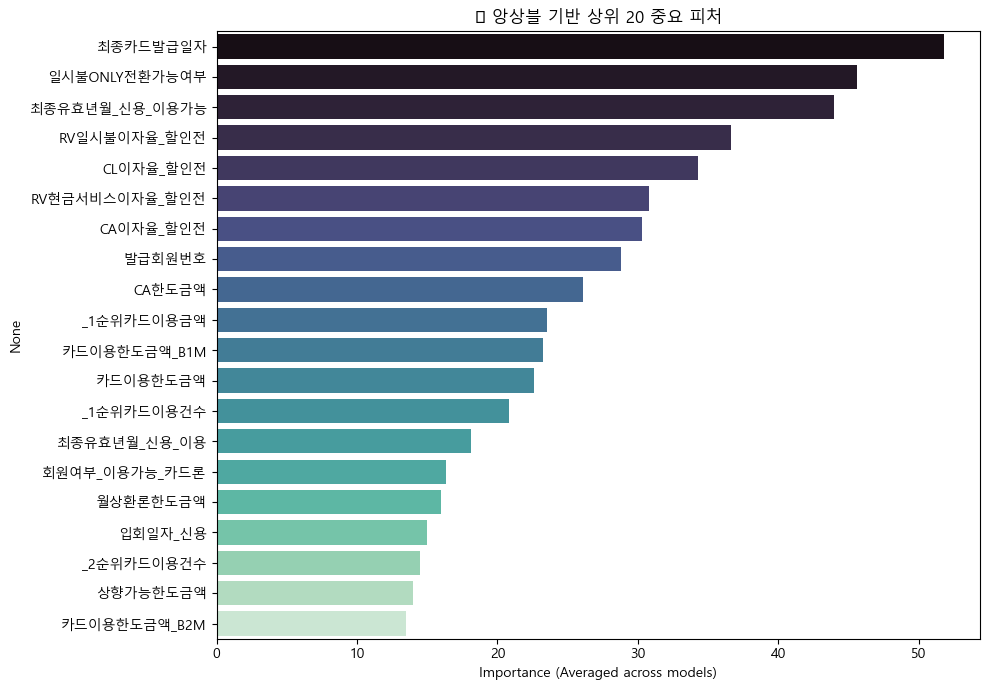

📊 상위 10개 중요 피처:
                RandomForest   XGBoost  LightGBM   CatBoost       Mean
최종카드발급일자            0.004884  0.000442       207   0.088230  51.773389
일시불ONLY전환가능여부       0.317428  0.955827        94  87.059183  45.583109
최종유효년월_신용_이용가능      0.018004  0.000921       174   1.866791  43.971429
RV일시불이자율_할인전        0.035762  0.000388       144   2.383217  36.604842
CL이자율_할인전           0.103394  0.000360       137   0.150403  34.313539
RV현금서비스이자율_할인전      0.046263  0.007394       122   1.123063  30.794180
CA이자율_할인전           0.074878  0.000654       121   0.089805  30.291334
발급회원번호              0.001698  0.000247       115   0.071464  28.768352
CA한도금액              0.006227  0.000326       104   0.468800  26.118838
_1순위카드이용금액          0.002391  0.000567        94   0.242461  23.561355


In [45]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 로드
df = pd.read_csv("201807_회원_통합.csv")
df = df.dropna(subset=['RV전환가능여부'])
y = df['RV전환가능여부']
X = df.drop(columns=['RV전환가능여부'])

# 2. 결측치 및 라벨 인코딩
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].fillna("missing")
    else:
        X[col] = X[col].fillna(-999)

for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# y 인코딩 ('N', 'Z' → 0, 1)
le_y = LabelEncoder()
y = le_y.fit_transform(y)

# 3. 학습/검증 분할 및 스케일링 (CatBoost 제외)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# 4. 모델 정의
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=100, random_state=42),
    "CatBoost": CatBoostClassifier(iterations=100, verbose=0, random_seed=42)
}

# 5. 모델 학습 및 중요도 저장
feature_names = X.columns
feature_importances = pd.DataFrame(index=feature_names)

for name, model in models.items():
    if name == "CatBoost":
        model.fit(X_train, y_train)
    else:
        model.fit(X_train_scaled, y_train)
    feature_importances[name] = model.feature_importances_

# 6. 평균 중요도 계산
feature_importances['Mean'] = feature_importances.mean(axis=1)

# 7. 중요도 순 정렬
top_features = feature_importances.sort_values(by='Mean', ascending=False)

# 8. 시각화
plt.figure(figsize=(10, 7))
sns.barplot(
    x='Mean',
    y=top_features.index[:20],
    data=top_features[:20].reset_index().rename(columns={'index': 'Feature'}),
    palette="mako"
)
plt.title("🎯 앙상블 기반 상위 20 중요 피처")
plt.xlabel("Importance (Averaged across models)")
plt.tight_layout()
plt.show()

# 9. 결과 출력
print("📊 상위 10개 중요 피처:")
print(top_features.head(10))


C:\Users\xison\AppData\Local\Temp\ipykernel_23168\2660485634.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
c:\Users\xison\anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


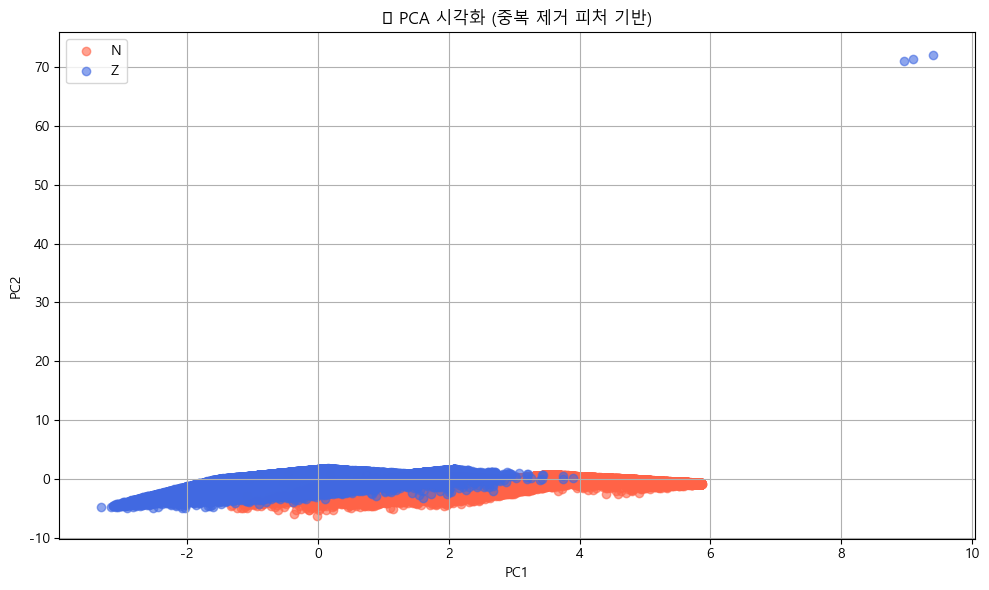

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 1. 데이터 로딩 및 전처리
df = pd.read_csv("201807_회원_통합.csv")
df = df.dropna(subset=['RV전환가능여부'])

selected_features = [
    '일시불ONLY전환가능여부',
    '최종카드발급일자',
    '최종유효년월_신용_이용가능',
    'RV일시불이자율_할인전',
    'CA한도금액',
    '_1순위카드이용금액'
]

X = df[selected_features].copy()
y = df['RV전환가능여부'].copy()

# 결측치 및 범주형 처리
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = pd.factorize(X[col])[0]
    else:
        X[col] = X[col].fillna(-999)

# y 인코딩
y_encoded = LabelEncoder().fit_transform(y)

# 스케일링
X_scaled = StandardScaler().fit_transform(X)

# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 시각화
plt.figure(figsize=(10, 6))
colors = ['tomato', 'royalblue']
labels = ['N', 'Z']
for i, label in enumerate([0, 1]):
    plt.scatter(X_pca[y_encoded == label, 0], X_pca[y_encoded == label, 1],
                c=colors[i], label=labels[i], alpha=0.6)
    
plt.title("📌 PCA 시각화 (중복 제거 피처 기반)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\xison\anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\xison\anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\xison\anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\xison\anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\xison\anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from

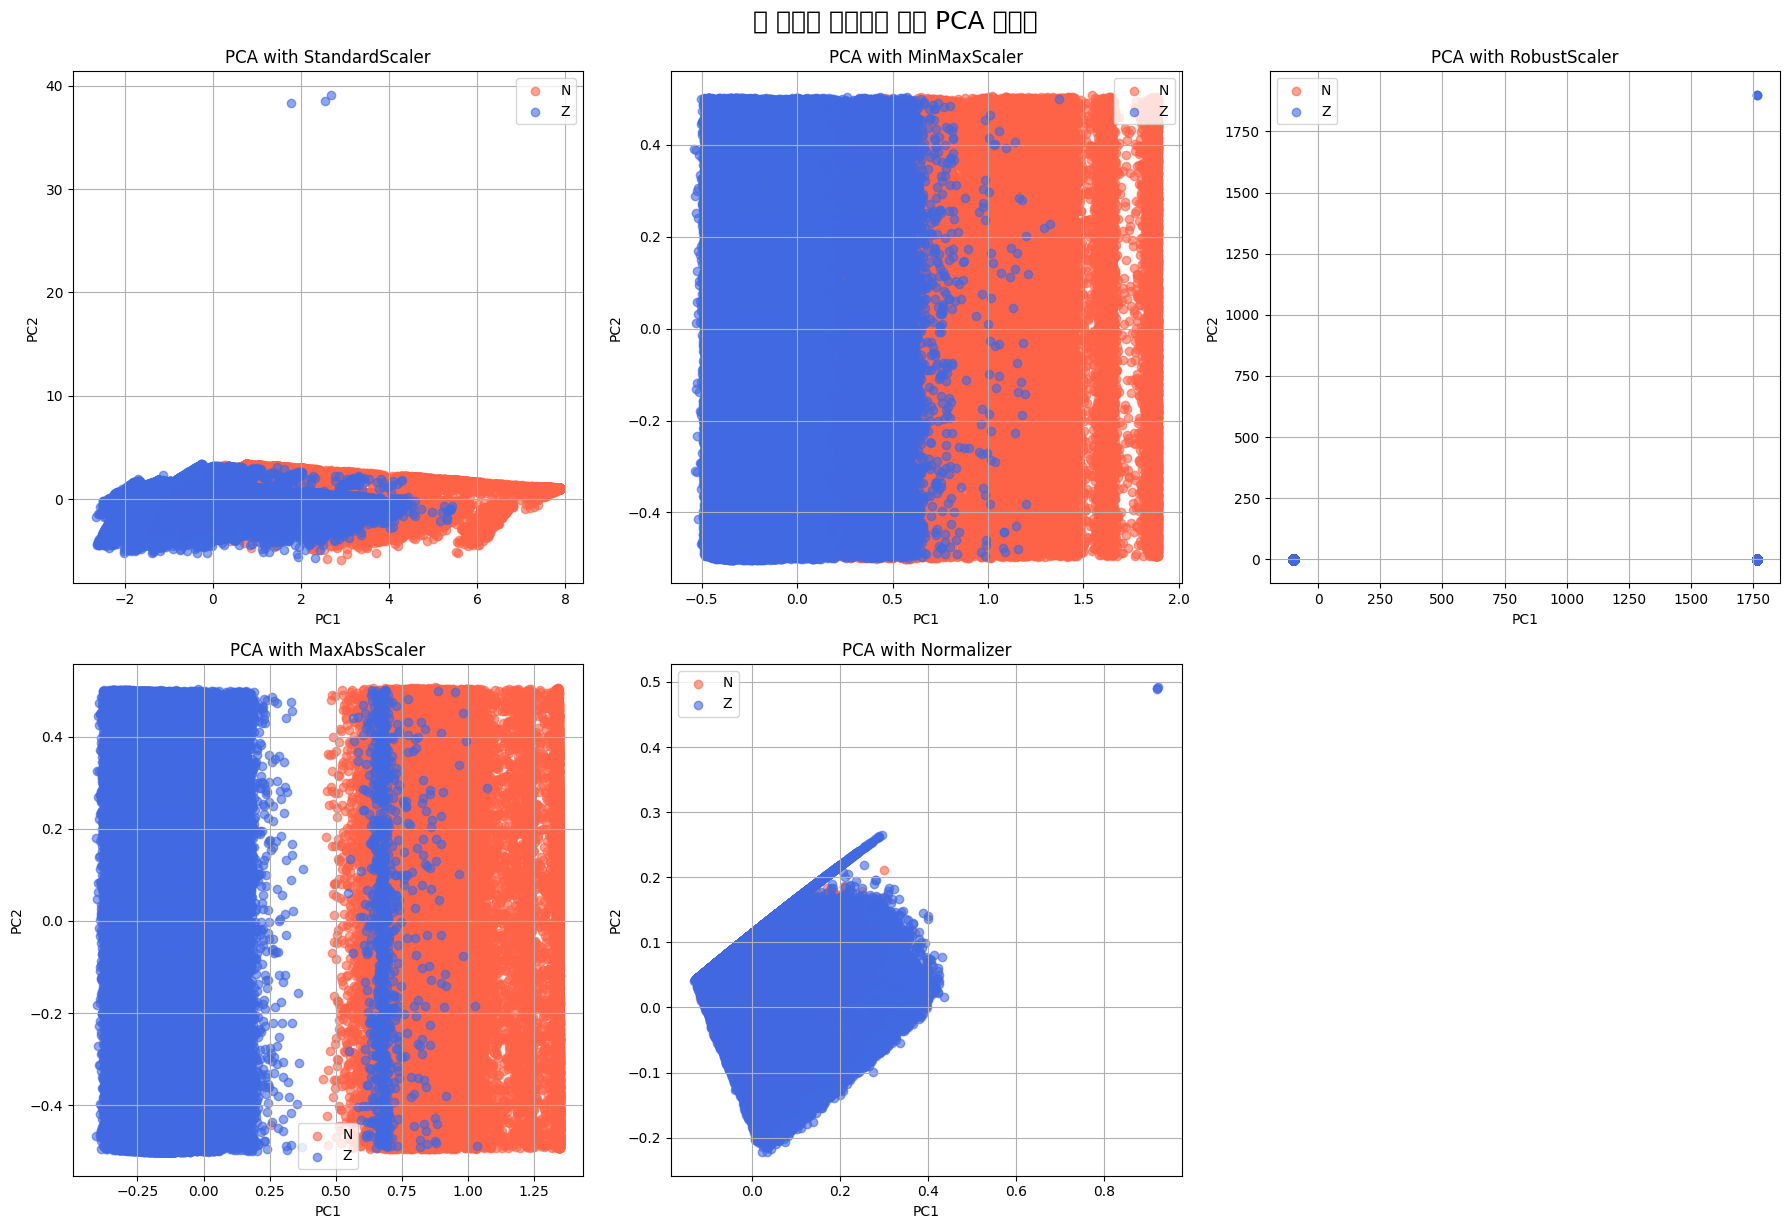

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler,
    MaxAbsScaler, Normalizer, LabelEncoder
)

# 1. 데이터 로딩 및 전처리
df = pd.read_csv("201807_회원_통합.csv")
df = df.dropna(subset=['RV전환가능여부'])

selected_features = [
    '최종카드발급일자',
    '일시불ONLY전환가능여부',
    '최종유효년월_신용_이용가능',
    'RV일시불이자율_할인전',
    'CL이자율_할인전',
    'RV현금서비스이자율_할인전',
    'CA이자율_할인전',
    '발급회원번호',
    'CA한도금액',
    '_1순위카드이용금액'
]

X = df[selected_features].copy()
y = df['RV전환가능여부'].copy()

# 결측치 및 범주형 처리
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = pd.factorize(X[col])[0]
    else:
        X[col] = X[col].fillna(-999)

# y 인코딩
y_encoded = LabelEncoder().fit_transform(y)

# 사용 가능한 스케일링 방법 정의
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'MaxAbsScaler': MaxAbsScaler(),
    'Normalizer': Normalizer()
}

# 시각화 색상 및 라벨 설정
colors = ['tomato', 'royalblue']
labels = ['N', 'Z']

# 전체 subplot 설정
plt.figure(figsize=(18, 12))
for i, (scaler_name, scaler) in enumerate(scalers.items(), 1):
    X_scaled = scaler.fit_transform(X)
    X_pca = PCA(n_components=2).fit_transform(X_scaled)

    plt.subplot(2, 3, i)
    for j, label in enumerate([0, 1]):
        plt.scatter(X_pca[y_encoded == label, 0], X_pca[y_encoded == label, 1],
                    c=colors[j], label=labels[j], alpha=0.6)
    plt.title(f"PCA with {scaler_name}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.suptitle("📌 다양한 스케일러 기반 PCA 시각화", fontsize=18, y=1.02)
plt.show()


수정사항(앙상블로 뽑아낸 피처에 대해서 앙상블로 모델링하기 즉 이전에 상관계수 이런거 보지 말기)

C:\Users\xison\AppData\Local\Temp\ipykernel_19720\3615765961.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['한도_대비_사용비율'].replace([np.inf, -np.inf], 0, inplace=True)


원본 학습 데이터 분포 -> 다수(1): 229600개, 소수(0): 44290개

===== 소수 클래스 1.5배 증가 (목표: 66435개) =====


c:\Users\xison\anaconda3\envs\pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [01:45:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 229600, number of negative: 66435
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 296035, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.775584 -> initscore=1.240115
[LightGBM] [Info] Start training from score 1.240115

===== 소수 클래스 2.0배 증가 (목표: 88580개) =====


c:\Users\xison\anaconda3\envs\pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [01:46:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 229600, number of negative: 88580
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 318180, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.721604 -> initscore=0.952433
[LightGBM] [Info] Start training from score 0.952433

===== 소수 클래스 2.5배 증가 (목표: 110725개) =====


c:\Users\xison\anaconda3\envs\pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [01:48:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 229600, number of negative: 110725
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 340325, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.674649 -> initscore=0.729289
[LightGBM] [Info] Start training from score 0.729289

===== 소수 클래스 3.0배 증가 (목표: 132870개) =====


c:\Users\xison\anaconda3\envs\pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [01:49:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 229600, number of negative: 132870
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 362470, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.633432 -> initscore=0.546967
[LightGBM] [Info] Start training from score 0.546967

===== 소수 클래스 3.5배 증가 (목표: 155015개) =====


c:\Users\xison\anaconda3\envs\pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [01:51:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 229600, number of negative: 155015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 384615, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596961 -> initscore=0.392817
[LightGBM] [Info] Start training from score 0.392817

===== 소수 클래스 4.0배 증가 (목표: 177160개) =====


c:\Users\xison\anaconda3\envs\pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [01:53:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 229600, number of negative: 177160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 406760, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564461 -> initscore=0.259285
[LightGBM] [Info] Start training from score 0.259285

===== 소수 클래스 4.5배 증가 (목표: 199305개) =====


c:\Users\xison\anaconda3\envs\pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [01:55:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 229600, number of negative: 199305
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 428905, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.535317 -> initscore=0.141502
[LightGBM] [Info] Start training from score 0.141502

===== 소수 클래스 5.0배 증가 (목표: 221450개) =====


c:\Users\xison\anaconda3\envs\pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [01:57:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 229600, number of negative: 221450
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 451050, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509034 -> initscore=0.036142
[LightGBM] [Info] Start training from score 0.036142

===== 소수 클래스 5.5배 증가 (목표: 229600개) =====


c:\Users\xison\anaconda3\envs\pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [01:59:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 229600, number of negative: 229600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 459200, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

✅ SMOTE 점진적 증가에 따른 성능 변화 그래프를 'smote_incremental_performance.png' 파일로 저장했습니다.


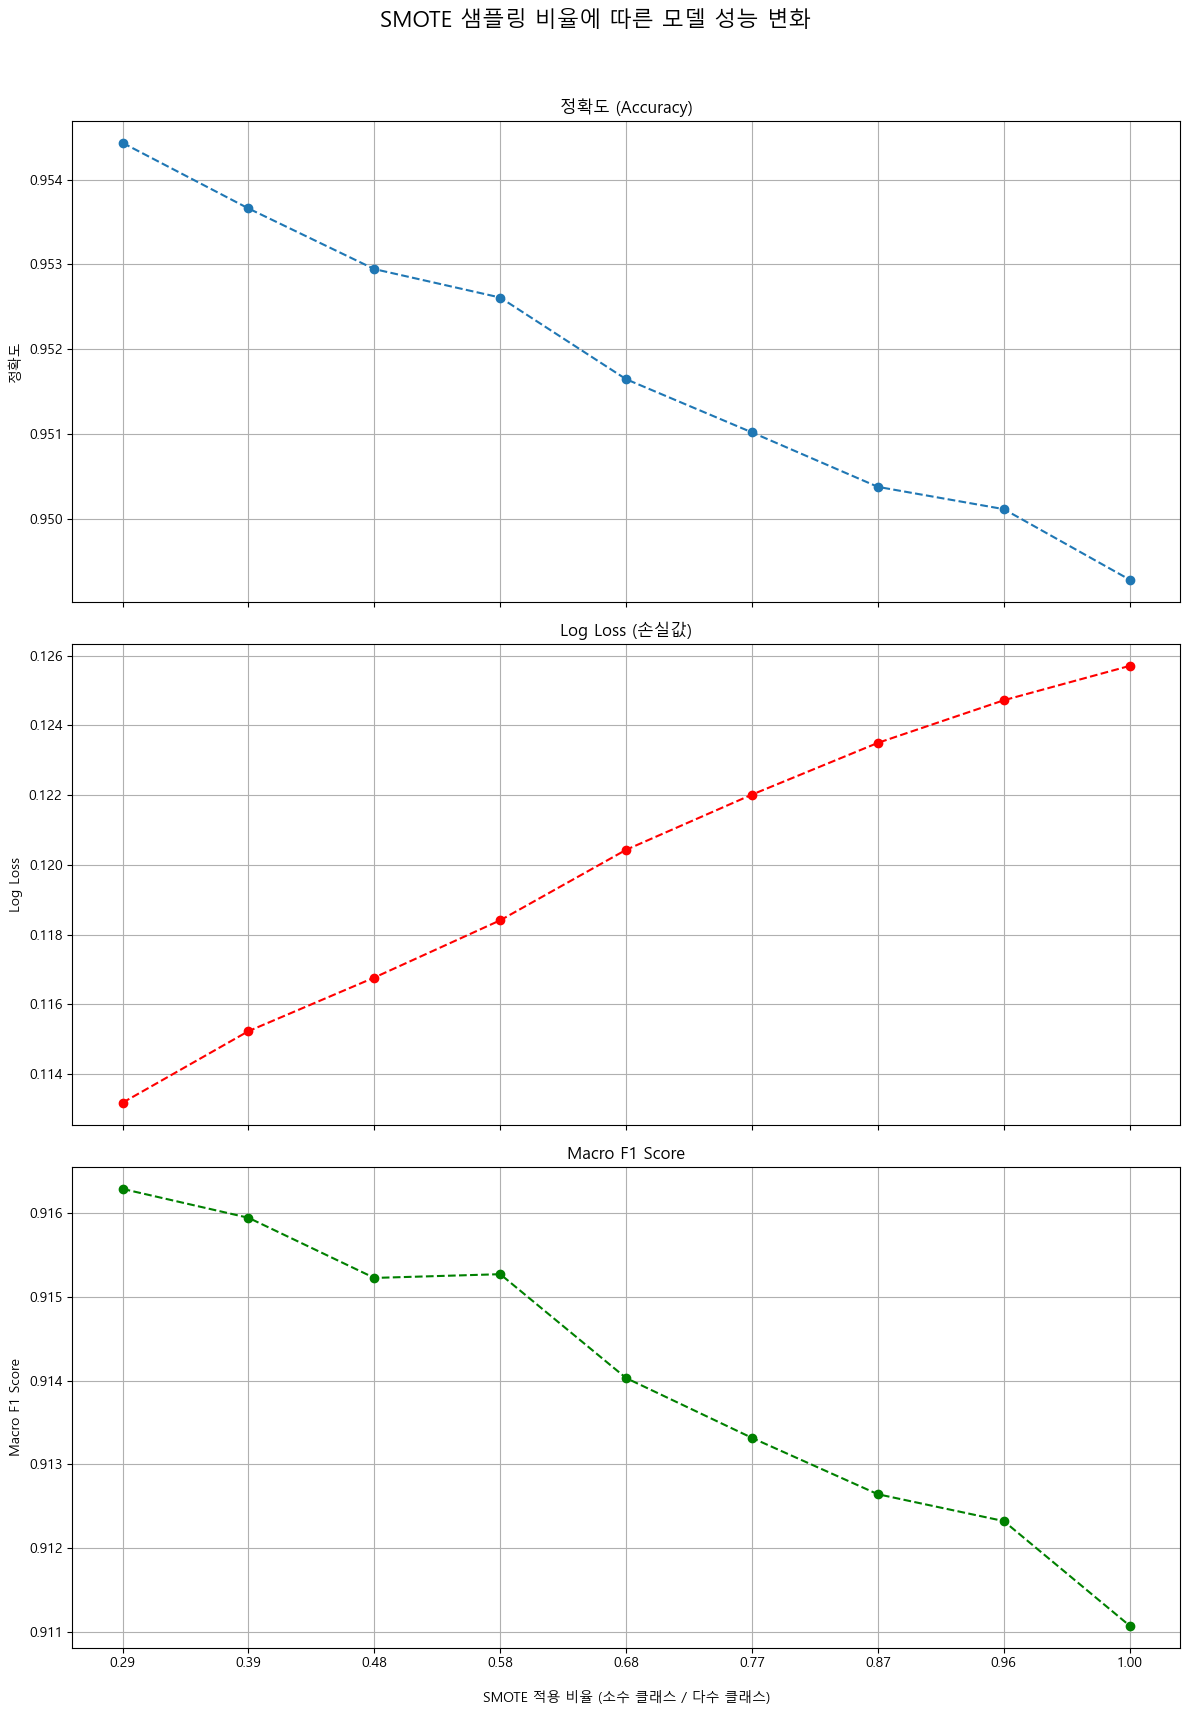

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, log_loss
from imblearn.over_sampling import SMOTE

# ----------------------------------------------------
# 한글 폰트 설정
# ----------------------------------------------------
try:
    import os
    if os.name == 'nt': # Windows
        font_path = 'c:/Windows/Fonts/malgun.ttf'
        font_name = fm.FontProperties(fname=font_path).get_name()
        plt.rc('font', family=font_name)
    elif os.uname().sysname == 'Darwin': # Mac
        plt.rc('font', family='AppleGothic')
    else: # Colab/Linux
        font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
        fm.fontManager.addfont(font_path)
        plt.rc('font', family='NanumGothic')
except Exception:
    pass
plt.rcParams['axes.unicode_minus'] = False

# ────────────────────────
# 1. 데이터 로딩 및 전처리 (이전과 동일)
# ────────────────────────
df = pd.read_csv("201807_회원_통합.csv")
df = df.dropna(subset=['RV전환가능여부'])
# ... (이전 코드와 동일한 전처리 로직) ...
selected_features = [
    '일시불ONLY전환가능여부', '최종카드발급일자', '최종유효년월_신용_이용가능', 'RV일시불이자율_할인전', 'CA한도금액', '_1순위카드이용금액'
]
X = df[selected_features].copy()
y = df['RV전환가능여부'].copy()
X['한도_대비_사용비율'] = X['_1순위카드이용금액'] / X['CA한도금액']
X['한도_대비_사용비율'].replace([np.inf, -np.inf], 0, inplace=True)
X['이자율_한도_상호작용'] = X['RV일시불이자율_할인전'] * X['CA한도금액']
X['일시불ONLY전환가능여부'] = X['일시불ONLY전환가능여부'].map({'N': 0, 'Y': 1}).fillna(0)
for col in X.columns:
    if X[col].dtype == 'object': X[col] = pd.factorize(X[col])[0]
    else: X[col] = X[col].fillna(X[col].mean())
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# ───────▼▼▼▼▼ 여기가 핵심 수정 부분 ▼▼▼▼▼───────

# ────────────────────────
# 2. SMOTE 점진적 증가 및 학습/평가 루프
# ────────────────────────
# 원본 학습 데이터의 클래스 분포 확인
counts = pd.Series(y_train).value_counts()
majority_label = counts.idxmax()
minority_label = counts.idxmin()
n_majority = counts[majority_label]
n_minority_original = counts[minority_label]

print(f"원본 학습 데이터 분포 -> 다수({majority_label}): {n_majority}개, 소수({minority_label}): {n_minority_original}개")

# 결과를 저장할 리스트
sampling_ratios_for_plot = []
results_accuracy = []
results_logloss = []
results_macro_f1 = []

# 소수 클래스를 원본의 0.5배씩 늘려나감
multiplier = 1.0 # 현재 배율 (1.0은 원본 상태)
increment = 0.5  # 증가량

while True:
    # 현재 배율에 따른 목표 소수 클래스 샘플 수 계산
    # multiplier가 1.0일때는 원본 상태이므로 1.5부터 시작하도록 함
    current_multiplier = multiplier + increment
    target_n_minority = int(n_minority_original * current_multiplier)
    
    # 목표 샘플 수가 다수 클래스 수를 넘으면 중단
    if target_n_minority > n_majority:
        # 마지막으로 1:1 비율을 한번 더 테스트하고 종료
        if (n_majority not in sampling_ratios_for_plot):
             target_n_minority = n_majority
        else:
            break
            
    print(f"\n===== 소수 클래스 {current_multiplier:.1f}배 증가 (목표: {target_n_minority}개) =====")

    # SMOTE에 목표 샘플 수를 직접 지정 (dictionary 방식)
    sampling_strategy_dict = {
        majority_label: n_majority,
        minority_label: target_n_minority
    }
    smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy_dict)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

    # 모델 정의 및 학습
    ensemble_model = VotingClassifier(
        estimators=[('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
                    ('xgb', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')),
                    ('lgbm', LGBMClassifier(random_state=42)),
                    ('cat', CatBoostClassifier(verbose=0, random_state=42))],
        voting='soft'
    )
    ensemble_model.fit(X_train_smote, y_train_smote)

    # 예측 및 평가
    y_pred = ensemble_model.predict(X_test_scaled)
    y_pred_proba = ensemble_model.predict_proba(X_test_scaled)
    
    # 결과 저장
    ratio_for_plot = target_n_minority / n_majority
    sampling_ratios_for_plot.append(ratio_for_plot)
    results_accuracy.append(accuracy_score(y_test, y_pred))
    results_logloss.append(log_loss(y_test, y_pred_proba))
    results_macro_f1.append(f1_score(y_test, y_pred, average='macro'))
    
    multiplier += increment
    
    # 1:1 비율을 테스트했으면 루프 종료
    if target_n_minority == n_majority:
        break

# ────────────────────────
# 3. 결과 시각화
# ────────────────────────
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
fig.suptitle('SMOTE 샘플링 비율에 따른 모델 성능 변화', fontsize=16)
x_labels = [f'{r:.2f}' for r in sampling_ratios_for_plot]

axes[0].plot(x_labels, results_accuracy, marker='o', linestyle='--')
axes[0].set_title('정확도 (Accuracy)')
axes[0].set_ylabel('정확도')
axes[0].grid(True)

axes[1].plot(x_labels, results_logloss, marker='o', linestyle='--', color='red')
axes[1].set_title('Log Loss (손실값)')
axes[1].set_ylabel('Log Loss')
axes[1].grid(True)

axes[2].plot(x_labels, results_macro_f1, marker='o', linestyle='--', color='green')
axes[2].set_title('Macro F1 Score')
axes[2].set_xlabel('\nSMOTE 적용 비율 (소수 클래스 / 다수 클래스)')
axes[2].set_ylabel('Macro F1 Score')
axes[2].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig("smote_incremental_performance.png")
print("\n✅ SMOTE 점진적 증가에 따른 성능 변화 그래프를 'smote_incremental_performance.png' 파일로 저장했습니다.")

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from scipy.stats import randint, uniform

# ────────────────────────
# 1. 데이터 로딩 및 전처리 (최종본)
# ────────────────────────
# 실제 파일 경로를 지정해야 합니다.
df = pd.read_csv("201807_회원_통합.csv")
df = df.dropna(subset=['RV전환가능여부'])

# 피처 엔지니어링
X = df[['일시불ONLY전환가능여부', '최종카드발급일자', '최종유효년월_신용_이용가능', 'RV일시불이자율_할인전', 'CA한도금액', '_1순위카드이용금액']].copy()
X['한도_대비_사용비율'] = X['_1순위카드이용금액'] / X['CA한도금액']
X['한도_대비_사용비율'].replace([np.inf, -np.inf], 0, inplace=True)
X['이자율_한도_상호작용'] = X['RV일시불이자율_할인전'] * X['CA한도금액']

# 최종 전처리
X['일시불ONLY전환가능여부'] = X['일시불ONLY전환가능여부'].map({'N': 0, 'Y': 1}).fillna(0)
for col in X.columns:
    if X[col].dtype == 'object': X[col] = pd.factorize(X[col])[0]
    else: X[col] = X[col].fillna(X[col].mean())
le = LabelEncoder()
y_encoded = df['RV전환가능여부'].copy()
y_encoded = le.fit_transform(y_encoded)

# ────────────────────────
# 2. 데이터 분할 및 스케일링 (최종본)
# ────────────────────────
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# ────────────────────────
# 3. 하이퍼파라미터 탐색 (LGBM 예시)
# ────────────────────────
print("🚀 LGBM 하이퍼파라미터 최적화를 시작합니다...")

param_dist_lgbm = {
    'n_estimators': randint(100, 1000), 'learning_rate': uniform(0.01, 0.1),
    'num_leaves': randint(20, 50), 'max_depth': [-1, 5, 10, 15],
    'subsample': uniform(0.6, 0.4), 'colsample_bytree': uniform(0.6, 0.4)
}
lgbm = LGBMClassifier(random_state=42, class_weight='balanced')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- ▼▼▼▼▼ 핵심 설정: Macro F1을 기준으로 모델을 최적화 ▼▼▼▼▼ ---
rand_search = RandomizedSearchCV(
    lgbm,
    param_distributions=param_dist_lgbm,
    n_iter=50, cv=cv,
    scoring='f1_macro', # Macro F1 점수가 가장 높은 파라미터를 찾도록 설정
    random_state=42, n_jobs=-1
)
# ----------------------------------------------------------------

rand_search.fit(X_train_scaled, y_train)
print(f"✅ LGBM 최적화 완료! Best Score (Macro F1): {rand_search.best_score_:.4f}")
print("Best Parameters found:", rand_search.best_params_)
best_lgbm = rand_search.best_estimator_


# ───────▼▼▼▼▼ 여기가 핵심 수정 부분 ▼▼▼▼▼───────

# ────────────────────────
# 4. 최적 모델로 최종 앙상블 구성 및 Macro F1 평가
# ────────────────────────
print("\n🔥 최적화된 LGBM으로 최종 앙상블 모델을 구성하여 평가합니다...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
cat = CatBoostClassifier(verbose=0, random_state=42)

final_ensemble_model = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('lgbm', best_lgbm), ('cat', cat)],
    voting='soft'
)
final_ensemble_model.fit(X_train_scaled, y_train)
y_pred = final_ensemble_model.predict(X_test_scaled)

# --- ▼▼▼▼▼ 최종 성능을 Macro F1 Score 중심으로 출력 ▼▼▼▼▼ ---
print("\n[최종 앙상블 모델 성능 평가]")

# 1. Macro F1 Score 계산 및 출력
# RandomizedSearchCV가 'f1_macro'를 기준으로 최적화했으므로,
# 테스트셋에서도 Macro F1 Score를 핵심 지표로 평가합니다.
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"✅ 최종 모델 Macro F1 Score: {macro_f1:.4f}")

# 2. 참고용: 전체 정확도(Micro F1)
acc = accuracy_score(y_test, y_pred)
print(f"   (참고) 정확도 (Accuracy): {acc:.4f}")

# 3. 전체 리포트에서도 'macro avg'의 f1-score를 통해 동일한 값을 확인할 수 있습니다.
print("\n[Classification Report]")
print(classification_report(y_test, y_pred, target_names=le.classes_))

C:\Users\xison\AppData\Local\Temp\ipykernel_19720\3660370818.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['한도_대비_사용비율'].replace([np.inf, -np.inf], 0, inplace=True)


🚀 LGBM 하이퍼파라미터 최적화를 시작합니다...
[LightGBM] [Info] Number of positive: 229600, number of negative: 44290
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1598
[LightGBM] [Info] Number of data points in the train set: 273890, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
✅ LGBM 최적화 완료! Best Score (Macro F1): 0.8998
Best Parameters found: {'colsample_bytree': 0.6806876809341584, 'learning_rate': 0.09957635956735193, 'max_depth': -1, 'n_estimators': 663, 'num_leaves': 48, 'subsample': 0.8034282764658811}

🔥 최적화된 LGBM으로 최종 앙상블 모델을 구성하여 평가합니다...


c:\Users\xison\anaconda3\envs\pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [17:22:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 229600, number of negative: 44290
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1598
[LightGBM] [Info] Number of data points in the train set: 273890, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

[최종 앙상블 모델 성능 평가]
✅ 최종 모델 Macro F1 Score: 0.9161
   (참고) 정확도 (Accuracy): 0.9540

[Classification Report]
              precision    recall  f1-score   support

           N       0.85      0.87      0.86     11073
           Z       0.98      0.97      0.97     57400

    accuracy                           0.95     68473
   macro avg       0.91      0.92      0.92     68473
weighted avg       0.95      0.95      0.95     68473



C:\Users\xison\AppData\Local\Temp\ipykernel_19720\1519516851.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['한도_대비_사용비율'].replace([np.inf, -np.inf], 0, inplace=True)


🚀 최종 앙상블 모델을 학습합니다...


c:\Users\xison\anaconda3\envs\pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [17:27:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 229600, number of negative: 44290
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1598
[LightGBM] [Info] Number of data points in the train set: 273890, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
✅ 학습이 완료되었습니다.

[최종 앙상블 모델 성능 평가]
              precision    recall  f1-score   support

           N       0.85      0.87      0.86     11073
           Z       0.98      0.97      0.97     57400

    accuracy                           0.95     68473
   macro avg       0.91      0.92      0.92     68473
weighted avg       0.95      0.95      0.95     68473


📊 최종 모델의 혼동 행렬을 시각화합니다...

✅ 최종 혼동 행렬 그래프를 'final_confusion_matrix.png' 파일로 저장했습니다.


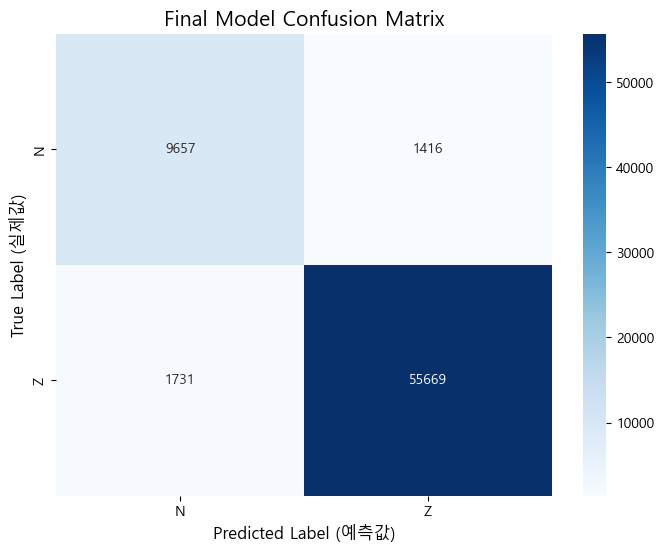

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns # 시각화를 위한 seaborn 라이브러리 추가
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# confusion_matrix 추가
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from scipy.stats import randint, uniform

# ----------------------------------------------------
# 한글 폰트 설정
# ----------------------------------------------------
try:
    import os
    if os.name == 'nt': # Windows
        font_path = 'c:/Windows/Fonts/malgun.ttf'
        font_name = fm.FontProperties(fname=font_path).get_name()
        plt.rc('font', family=font_name)
    elif os.uname().sysname == 'Darwin': # Mac
        plt.rc('font', family='AppleGothic')
    else: # Colab/Linux
        font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
        fm.fontManager.addfont(font_path)
        plt.rc('font', family='NanumGothic')
except Exception as e:
    print(f"한글 폰트 설정 중 오류 발생: {e}")
    pass
plt.rcParams['axes.unicode_minus'] = False


# ────────────────────────
# 1 & 2. 데이터 로딩, 전처리, 분할, 스케일링
# ────────────────────────
# (코드는 이전 답변과 동일하므로 생략)
df = pd.read_csv("201807_회원_통합.csv")
df = df.dropna(subset=['RV전환가능여부'])
X = df[['일시불ONLY전환가능여부', '최종카드발급일자', '최종유효년월_신용_이용가능', 'RV일시불이자율_할인전', 'CA한도금액', '_1순위카드이용금액']].copy()
X['한도_대비_사용비율'] = X['_1순위카드이용금액'] / X['CA한도금액']
X['한도_대비_사용비율'].replace([np.inf, -np.inf], 0, inplace=True)
X['이자율_한도_상호작용'] = X['RV일시불이자율_할인전'] * X['CA한도금액']
X['일시불ONLY전환가능여부'] = X['일시불ONLY전환가능여부'].map({'N': 0, 'Y': 1}).fillna(0)
for col in X.columns:
    if X[col].dtype == 'object': X[col] = pd.factorize(X[col])[0]
    else: X[col] = X[col].fillna(X[col].mean())
le = LabelEncoder()
y_encoded = df['RV전환가능여부'].copy()
y_encoded = le.fit_transform(y_encoded)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# ────────────────────────
# 3. 하이퍼파라미터 탐색 및 최종 모델 구성
# ────────────────────────
# 여기서는 간단하게 이전에 찾은 최적 파라미터를 사용한다고 가정하겠습니다.
# 실제로는 매번 실행해야 하지만, 시연을 위해 찾은 값을 직접 입력합니다.
best_params = {'colsample_bytree': 0.68, 'learning_rate': 0.099, 'max_depth': -1, 'n_estimators': 663, 'num_leaves': 48, 'subsample': 0.803}
best_lgbm = LGBMClassifier(random_state=42, class_weight='balanced', **best_params)

# 다른 모델들은 기본값으로 둠
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
cat = CatBoostClassifier(verbose=0, random_state=42)

final_ensemble_model = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('lgbm', best_lgbm), ('cat', cat)],
    voting='soft'
)
print("🚀 최종 앙상블 모델을 학습합니다...")
final_ensemble_model.fit(X_train_scaled, y_train)
print("✅ 학습이 완료되었습니다.")

# 최종 모델로 예측 수행
y_pred = final_ensemble_model.predict(X_test_scaled)


# ───────▼▼▼▼▼ 여기가 핵심 추가 부분 ▼▼▼▼▼───────

# ────────────────────────
# 4. 최종 성능 평가 및 혼동 행렬 시각화
# ────────────────────────
print("\n[최종 앙상블 모델 성능 평가]")
# Classification Report 출력
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 혼동 행렬 계산 및 시각화
print("\n📊 최종 모델의 혼동 행렬을 시각화합니다...")
cm = confusion_matrix(y_test, y_pred)
class_labels = le.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Final Model Confusion Matrix', fontsize=15)
plt.ylabel('True Label (실제값)', fontsize=12)
plt.xlabel('Predicted Label (예측값)', fontsize=12)
plt.savefig("final_confusion_matrix.png")
# plt.show()
print("\n✅ 최종 혼동 행렬 그래프를 'final_confusion_matrix.png' 파일로 저장했습니다.")

C:\Users\xison\AppData\Local\Temp\ipykernel_19720\565080027.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['한도_대비_사용비율'].replace([np.inf, -np.inf], 0, inplace=True)


[LightGBM] [Info] Number of positive: 229600, number of negative: 44290
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1598
[LightGBM] [Info] Number of data points in the train set: 273890, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.838293 -> initscore=1.645580
[LightGBM] [Info] Start training from score 1.645580

✨ t-SNE 시각화를 시작합니다 (계산에 시간이 다소 소요될 수 있습니다)...

✅ t-SNE 시각화 그래프를 'tsne_visualization.png' 파일로 저장했습니다.


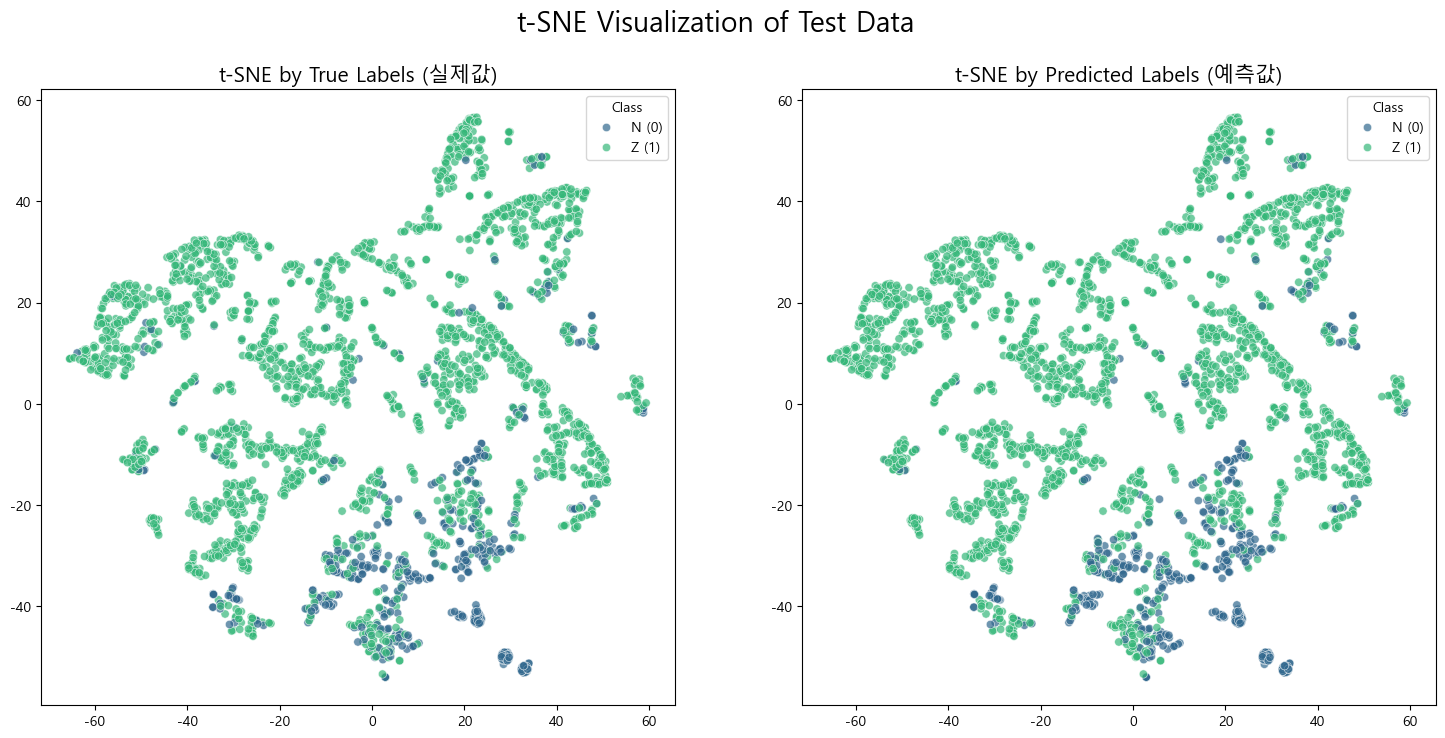

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
# t-SNE 임포트
from sklearn.manifold import TSNE


# ----------------------------------------------------
# 한글 폰트 설정
# ----------------------------------------------------
try:
    import os
    if os.name == 'nt': # Windows
        font_path = 'c:/Windows/Fonts/malgun.ttf'
        font_name = fm.FontProperties(fname=font_path).get_name()
        plt.rc('font', family=font_name)
    elif os.uname().sysname == 'Darwin': # Mac
        plt.rc('font', family='AppleGothic')
    else: # Colab/Linux
        font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
        fm.fontManager.addfont(font_path)
        plt.rc('font', family='NanumGothic')
except Exception as e:
    print(f"한글 폰트 설정 중 오류 발생: {e}")
    pass
plt.rcParams['axes.unicode_minus'] = False


# ────────────────────────
# 1, 2, 3. 데이터 로딩, 전처리, 분할, 스케일링, 모델 학습 (이전과 동일)
# ────────────────────────
# (코드가 길어 생략, 이전 답변의 코드와 동일합니다)
df = pd.read_csv("201807_회원_통합.csv")
df = df.dropna(subset=['RV전환가능여부'])
X = df[['일시불ONLY전환가능여부', '최종카드발급일자', '최종유효년월_신용_이용가능', 'RV일시불이자율_할인전', 'CA한도금액', '_1순위카드이용금액']].copy()
X['한도_대비_사용비율'] = X['_1순위카드이용금액'] / X['CA한도금액']
X['한도_대비_사용비율'].replace([np.inf, -np.inf], 0, inplace=True)
X['이자율_한도_상호작용'] = X['RV일시불이자율_할인전'] * X['CA한도금액']
X['일시불ONLY전환가능여부'] = X['일시불ONLY전환가능여부'].map({'N': 0, 'Y': 1}).fillna(0)
for col in X.columns:
    if X[col].dtype == 'object': X[col] = pd.factorize(X[col])[0]
    else: X[col] = X[col].fillna(X[col].mean())
le = LabelEncoder()
y_encoded = df['RV전환가능여부'].copy()
y_encoded = le.fit_transform(y_encoded)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# 간단한 시연을 위해 기본 모델 사용
final_ensemble_model = VotingClassifier(estimators=[('rf', RandomForestClassifier(n_estimators=100, random_state=42)), ('xgb', XGBClassifier(random_state=42)), ('lgbm', LGBMClassifier(random_state=42)), ('cat', CatBoostClassifier(verbose=0, random_state=42))], voting='soft')
final_ensemble_model.fit(X_train_scaled, y_train)
y_pred = final_ensemble_model.predict(X_test_scaled)


# ───────▼▼▼▼▼ 여기가 핵심 추가 부분 ▼▼▼▼▼───────

# ────────────────────────
# 4. t-SNE 시각화
# ────────────────────────
print("\n✨ t-SNE 시각화를 시작합니다 (계산에 시간이 다소 소요될 수 있습니다)...")

# 1. 계산 비용 문제로 테스트 데이터에서 3000개만 랜덤 샘플링
n_samples = 3000
random_indices = np.random.choice(X_test_scaled.shape[0], size=n_samples, replace=False)

X_sample = X_test_scaled[random_indices]
y_test_sample = y_test[random_indices]
y_pred_sample = y_pred[random_indices]

# 2. t-SNE 모델 생성 및 학습
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_sample)

# 3. 시각화 (실제값 vs 예측값)
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
class_labels = le.classes_ # ['N', 'Z']

# 실제값(True Labels)으로 그린 t-SNE
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_test_sample, ax=axes[0], palette='viridis', alpha=0.7)
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, [f"{class_labels[int(l)]} ({l})" for l in labels], title='Class')
axes[0].set_title('t-SNE by True Labels (실제값)', fontsize=15)

# 모델 예측값(Predicted Labels)으로 그린 t-SNE
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_pred_sample, ax=axes[1], palette='viridis', alpha=0.7)
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles, [f"{class_labels[int(l)]} ({l})" for l in labels], title='Class')
axes[1].set_title('t-SNE by Predicted Labels (예측값)', fontsize=15)

plt.suptitle('t-SNE Visualization of Test Data', fontsize=20)
plt.savefig("tsne_visualization.png")
# plt.show()
print("\n✅ t-SNE 시각화 그래프를 'tsne_visualization.png' 파일로 저장했습니다.")

🛠️  정교한 피처 엔지니어링을 시작합니다...


C:\Users\xison\AppData\Local\Temp\ipykernel_19720\1452482573.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['최종유효년월_신용_이용가능'].fillna(mode_value, inplace=True)
C:\Users\xison\AppData\Local\Temp\ipykernel_19720\1452482573.py:62: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



✅ 새로운 시간 기반 피처들이 추가되었습니다.

🚀 풍부해진 피처로 모델 학습을 시작합니다...


c:\Users\xison\anaconda3\envs\pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [17:46:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 229600, number of negative: 44290
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1803
[LightGBM] [Info] Number of data points in the train set: 273890, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
✅ 학습이 완료되었습니다.

✨ 최적 임계값: 0.4184

--- 최적 임계값 적용 결과 ---
              precision    recall  f1-score   support

           N       0.87      0.84      0.85     11073
           Z       0.97      0.98      0.97     57400

    accuracy                           0.95     68473
   macro avg       0.92      0.91      0.91     68473
weighted avg       0.95      0.95      0.95     68473


✨ t-SNE 시각화를 시작합니다 (계산에 시간이 다소 소요될 수 있습니다)...

✅ 최종 t-SNE 시각화 그래프를 'final_tsne_visualization.png' 파일로 저장했습니다.


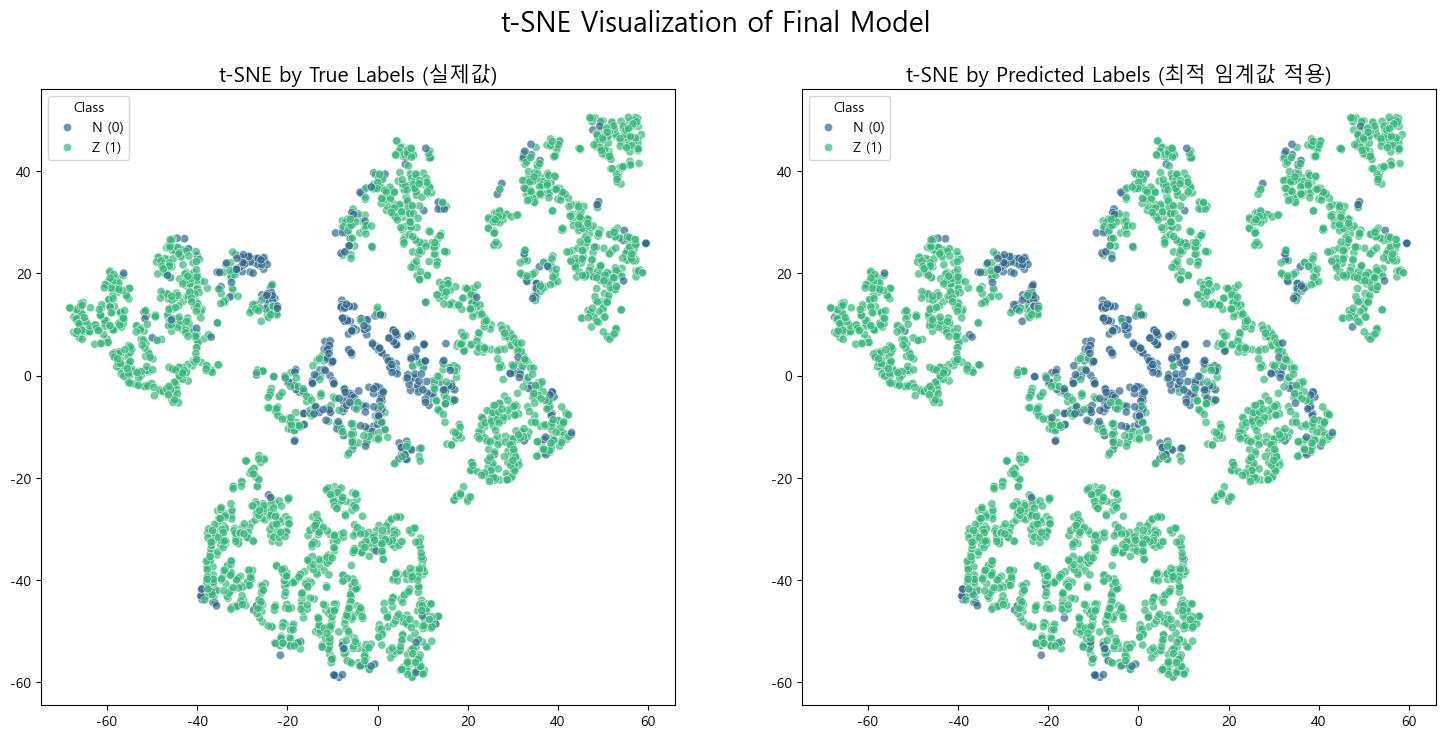

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve, f1_score
from sklearn.manifold import TSNE

# ----------------------------------------------------
# 한글 폰트 설정
# ----------------------------------------------------
try:
    import os
    if os.name == 'nt': # Windows
        font_path = 'c:/Windows/Fonts/malgun.ttf'
        font_name = fm.FontProperties(fname=font_path).get_name()
        plt.rc('font', family=font_name)
    elif os.uname().sysname == 'Darwin': # Mac
        plt.rc('font', family='AppleGothic')
    else: # Colab/Linux
        font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
        fm.fontManager.addfont(font_path)
        plt.rc('font', family='NanumGothic')
except Exception as e:
    print(f"한글 폰트 설정 중 오류 발생: {e}")
    pass
plt.rcParams['axes.unicode_minus'] = False


# ────────────────────────
# 1. 정교한 피처 엔지니어링
# ────────────────────────
print("🛠️  정교한 피처 엔지니어링을 시작합니다...")
df = pd.read_csv("201807_회원_통합.csv")
df = df.dropna(subset=['RV전환가능여부'])

# --- 날짜 데이터를 datetime 객체로 변환 ---
df['최종카드발급일자_dt'] = pd.to_datetime(df['최종카드발급일자'], format='%Y%m%d')

# ▼▼▼▼▼ 여기가 핵심 수정 부분 ▼▼▼▼▼
# 1. 결측치(NaN)를 가장 빈도가 높은 값(최빈값)으로 채움
mode_value = df['최종유효년월_신용_이용가능'].mode()[0]
df['최종유효년월_신용_이용가능'].fillna(mode_value, inplace=True)

# 2. .astype(int)를 적용하여 float -> int -> str 순서로 변환
df['최종유효년월_dt'] = pd.to_datetime(df['최종유효년월_신용_이용가능'].astype(int).astype(str) + '01', format='%Y%m%d')
# ▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲

df['카드보유기간_일'] = (df['최종유효년월_dt'] - df['최종카드발급일자_dt']).dt.days
current_date = datetime.now()
df['발급경과일'] = (current_date - df['최종카드발급일자_dt']).dt.days
df['발급연도'] = df['최종카드발급일자_dt'].dt.year
df['발급월'] = df['최종카드발급일자_dt'].dt.month
df['한도_대비_사용비율'] = df['_1순위카드이용금액'] / df['CA한도금액']
df['한도_대비_사용비율'].replace([np.inf, -np.inf], 0, inplace=True)
df['이자율_한도_상호작용'] = df['RV일시불이자율_할인전'] * df['CA한도금액']
print("✅ 새로운 시간 기반 피처들이 추가되었습니다.")

selected_features = [
    '일시불ONLY전환가능여부', 'RV일시불이자율_할인전', 'CA한도금액', '_1순위카드이용금액',
    '카드보유기간_일', '발급경과일', '발급연도', '발급월',
    '한도_대비_사용비율', '이자율_한도_상호작용'
]
X = df[selected_features].copy()
y = df['RV전환가능여부'].copy()

X['일시불ONLY전환가능여부'] = X['일시불ONLY전환가능여부'].map({'N': 0, 'Y': 1}).fillna(0)
# 결측치 처리 루프는 그대로 둡니다 (다른 컬럼에 적용될 수 있으므로)
for col in X.columns:
    if X[col].isnull().any():
        X[col] = X[col].fillna(X[col].mean())
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ────────────────────────
# 2. 데이터 분할, 스케일링, 모델 학습
# ────────────────────────
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
lgbm = LGBMClassifier(random_state=42, class_weight='balanced')
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
cat = CatBoostClassifier(verbose=0, random_state=42)
final_ensemble_model = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb), ('lgbm', lgbm), ('cat', cat)], voting='soft')
print("\n🚀 풍부해진 피처로 모델 학습을 시작합니다...")
final_ensemble_model.fit(X_train_scaled, y_train)
print("✅ 학습이 완료되었습니다.")


# ────────────────────────
# 3. 최적 임계값 탐색 및 성능 비교
# ────────────────────────
y_scores = final_ensemble_model.predict_proba(X_test_scaled)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
f1_scores = np.nan_to_num(f1_scores)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"\n✨ 최적 임계값: {optimal_threshold:.4f}")
y_pred_optimal = (y_scores >= optimal_threshold).astype(int)
print("\n--- 최적 임계값 적용 결과 ---")
print(classification_report(y_test, y_pred_optimal, target_names=le.classes_))


# ────────────────────────
# 4. t-SNE 시각화
# ────────────────────────
print("\n✨ t-SNE 시각화를 시작합니다 (계산에 시간이 다소 소요될 수 있습니다)...")
n_samples = 3000
# 테스트 데이터가 3000개보다 적을 경우, 전체 데이터를 사용
if len(X_test_scaled) < n_samples:
    n_samples = len(X_test_scaled)
    
random_indices = np.random.choice(X_test_scaled.shape[0], size=n_samples, replace=False)
X_sample = X_test_scaled[random_indices]
y_test_sample = y_test[random_indices]
y_pred_optimal_sample = y_pred_optimal[random_indices]
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, n_samples - 1), n_iter=1000)
X_tsne = tsne.fit_transform(X_sample)
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
class_labels = le.classes_
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_test_sample, ax=axes[0], palette='viridis', alpha=0.7)
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, [f"{class_labels[int(l)]} ({l})" for l in labels], title='Class')
axes[0].set_title('t-SNE by True Labels (실제값)', fontsize=15)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_pred_optimal_sample, ax=axes[1], palette='viridis', alpha=0.7)
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles, [f"{class_labels[int(l)]} ({l})" for l in labels], title='Class')
axes[1].set_title('t-SNE by Predicted Labels (최적 임계값 적용)', fontsize=15)
plt.suptitle('t-SNE Visualization of Final Model', fontsize=20)
plt.savefig("final_tsne_visualization.png")
print("\n✅ 최종 t-SNE 시각화 그래프를 'final_tsne_visualization.png' 파일로 저장했습니다.")

🛠️ 정교한 피처 엔지니어링을 시작합니다...


C:\Users\xison\AppData\Local\Temp\ipykernel_19720\519794462.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['최종유효년월_신용_이용가능'].fillna(mode_value, inplace=True)
C:\Users\xison\AppData\Local\Temp\ipykernel_19720\519794462.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

✅ 새로운 시간 기반 피처들이 추가되었습니다.

🚀 풍부해진 피처로 모델 학습을 시작합니다...


c:\Users\xison\anaconda3\envs\pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [17:57:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 229600, number of negative: 44290
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1803
[LightGBM] [Info] Number of data points in the train set: 273890, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
✅ 학습이 완료되었습니다.

✨ 최적 임계값: 0.4184

[최적 임계값 적용 결과 리포트]
              precision    recall  f1-score   support

           N       0.87      0.84      0.85     11073
           Z       0.97      0.98      0.97     57400

    accuracy                           0.95     68473
   macro avg       0.92      0.91      0.91     68473
weighted avg       0.95      0.95      0.95     68473


📊 최종 모델의 혼동 행렬을 시각화합니다...

✅ 최종 혼동 행렬 그래프를 'final_optimal_confusion_matrix.png' 파일로 저장했습니다.


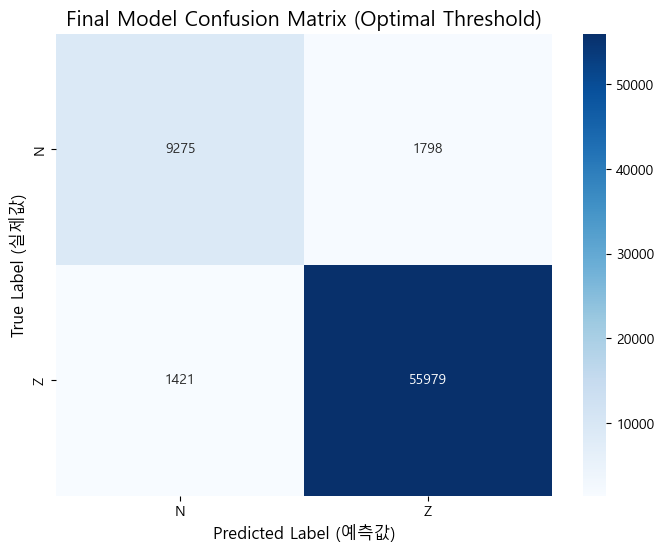

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# confusion_matrix를 포함한 모든 필요한 라이브러리 임포트
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve, f1_score, confusion_matrix
from sklearn.manifold import TSNE


# ----------------------------------------------------
# 한글 폰트 설정
# ----------------------------------------------------
try:
    import os
    if os.name == 'nt': # Windows
        font_path = 'c:/Windows/Fonts/malgun.ttf'
        font_name = fm.FontProperties(fname=font_path).get_name()
        plt.rc('font', family=font_name)
    elif os.uname().sysname == 'Darwin': # Mac
        plt.rc('font', family='AppleGothic')
    else: # Colab/Linux
        font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
        fm.fontManager.addfont(font_path)
        plt.rc('font', family='NanumGothic')
except Exception as e:
    print(f"한글 폰트 설정 중 오류 발생: {e}")
    pass
plt.rcParams['axes.unicode_minus'] = False


# ────────────────────────
# 1. 정교한 피처 엔지니어링
# ────────────────────────
print("🛠️ 정교한 피처 엔지니어링을 시작합니다...")
df = pd.read_csv("201807_회원_통합.csv")
df = df.dropna(subset=['RV전환가능여부'])

df['최종카드발급일자_dt'] = pd.to_datetime(df['최종카드발급일자'], format='%Y%m%d')
mode_value = df['최종유효년월_신용_이용가능'].mode()[0]
df['최종유효년월_신용_이용가능'].fillna(mode_value, inplace=True)
df['최종유효년월_dt'] = pd.to_datetime(df['최종유효년월_신용_이용가능'].astype(int).astype(str) + '01', format='%Y%m%d')

df['카드보유기간_일'] = (df['최종유효년월_dt'] - df['최종카드발급일자_dt']).dt.days
df['발급경과일'] = (datetime.now() - df['최종카드발급일자_dt']).dt.days
df['발급연도'] = df['최종카드발급일자_dt'].dt.year
df['발급월'] = df['최종카드발급일자_dt'].dt.month
df['한도_대비_사용비율'] = df['_1순위카드이용금액'] / df['CA한도금액']
df['한도_대비_사용비율'].replace([np.inf, -np.inf], 0, inplace=True)
df['이자율_한도_상호작용'] = df['RV일시불이자율_할인전'] * df['CA한도금액']
print("✅ 새로운 시간 기반 피처들이 추가되었습니다.")

selected_features = [
    '일시불ONLY전환가능여부', 'RV일시불이자율_할인전', 'CA한도금액', '_1순위카드이용금액',
    '카드보유기간_일', '발급경과일', '발급연도', '발급월',
    '한도_대비_사용비율', '이자율_한도_상호작용'
]
X = df[selected_features].copy()
y = df['RV전환가능여부'].copy()

X['일시불ONLY전환가능여부'] = X['일시불ONLY전환가능여부'].map({'N': 0, 'Y': 1}).fillna(0)
for col in X.columns:
    if X[col].isnull().any():
        X[col] = X[col].fillna(X[col].mean())
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ────────────────────────
# 2. 데이터 분할, 스케일링, 모델 학습
# ────────────────────────
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
lgbm = LGBMClassifier(random_state=42, class_weight='balanced')
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
cat = CatBoostClassifier(verbose=0, random_state=42)
final_ensemble_model = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb), ('lgbm', lgbm), ('cat', cat)], voting='soft')

print("\n🚀 풍부해진 피처로 모델 학습을 시작합니다...")
final_ensemble_model.fit(X_train_scaled, y_train)
print("✅ 학습이 완료되었습니다.")


# ────────────────────────
# 3. 최적 임계값 탐색 및 예측
# ────────────────────────
y_scores = final_ensemble_model.predict_proba(X_test_scaled)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
f1_scores = np.nan_to_num(f1_scores)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"\n✨ 최적 임계값: {optimal_threshold:.4f}")
y_pred_optimal = (y_scores >= optimal_threshold).astype(int)


# ───────▼▼▼▼▼ 여기가 핵심 추가 부분 ▼▼▼▼▼───────

# ────────────────────────
# 4. 최종 성능 평가 및 혼동 행렬 시각화
# ────────────────────────
print("\n[최적 임계값 적용 결과 리포트]")
print(classification_report(y_test, y_pred_optimal, target_names=le.classes_))

# 혼동 행렬 계산 및 시각화
print("\n📊 최종 모델의 혼동 행렬을 시각화합니다...")
cm = confusion_matrix(y_test, y_pred_optimal)
class_labels = le.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Final Model Confusion Matrix (Optimal Threshold)', fontsize=15)
plt.ylabel('True Label (실제값)', fontsize=12)
plt.xlabel('Predicted Label (예측값)', fontsize=12)
plt.savefig("final_optimal_confusion_matrix.png")
# plt.show()
print("\n✅ 최종 혼동 행렬 그래프를 'final_optimal_confusion_matrix.png' 파일로 저장했습니다.")